# Reconstruction framework for 5D hyperpolarized MRI using compress sensing.

### 

In [33]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt
import pylops
import pyproximal
from scipy.signal import find_peaks
from brainweb_dl import get_mri
from scipy.ndimage import zoom
from scipy.integrate import odeint
from skimage.metrics import mean_squared_error
from scipy.signal import find_peaks
from joblib import Parallel, delayed
from numba import njit, prange


## Creating a phantom representing a 5D cartography of the brain. 

In [81]:
class Phantom_5D_HP_MRI:
    """
    A class representing a 5D High-Resolution MRI Phantom.

    This class provides methods to create a 5D MRI phantom by simulating the
    spectral data for each voxel over time.
    The phantom is generated based on the provided MRI data, chemical shifts,
    peak widths, intensity ratios, and kinetic model parameters.

    Attributes:
    - sub_id (int): Subject ID for fetching MRI data.
    - contrast (str): Contrast type for fetching MRI data.
    - size (tuple): Size of the resized brain image.
    - acquisition_time (int): Total acquisition time for the simulation.
    - time_points (int): Number of time points for the simulation.
    - spectral_length (int): Length of the spectral data.

    Methods:
    - resize_brain_image(image, new_size): Resize 3D brain image to new size.
    - create_chemical_tumor(spot_locations, tumor_radius, image_shape):
    Create a chemical tumor in the brain image.
    - two_species_model(y, t, k_SP, R1_S, R1_P): Define the two-species
      kinetic model.
    - make_5D_HP_MRI_phantom(): Generate the 5D MRI phantom.

    """

    def __init__(self, sub_id=45, contrast="T1", size=(30, 30, 24),
                 acquisition_time=120, time_points=10, spectral_length=100):
        self.sub_id = sub_id
        self.contrast = contrast
        self.size = size
        self.acquisition_time = acquisition_time
        self.time_points = time_points
        self.spectral_length = spectral_length

    def resize_brain_image(self, image, new_size):
        """
        Resize a 3D brain image to a new size.

        Parameters:
        - image: 3D numpy array, original brain image.
        - new_size: tuple of ints, desired new size.

        Returns:
        - resized_image: 3D numpy array, resized brain image of shape new_size.
        """
        zoom_factors = [n / o for n, o in zip(new_size, image.shape)]
        resized_image = zoom(image, zoom_factors, order=3)
        return resized_image

    def create_chemical_tumor(self, spot_locations, tumor_radius, image_shape):
        """
        Create a chemical tumor in the brain image.

        Parameters:
        - spot_locations: dict, dictionary of spot locations for each chemical.
        - tumor_radius: int, radius of the tumor.
        - image_shape: tuple of ints, shape of the brain image.

        Returns:
        - chemical_tumor: 3D numpy array, brain image with the chemical tumor.
        """
        chemical_tumor = np.zeros(image_shape)
        max_radius = np.sqrt(
            image_shape[0] ** 2 +
            image_shape[1] ** 2 +
            image_shape[2] ** 2
        )
        for x in range(image_shape[0]):
            for y in range(image_shape[1]):
                for z in range(image_shape[2]):
                    radius = np.sqrt(
                        (x - spot_locations[0]) ** 2 +
                        (y - spot_locations[1]) ** 2 +
                        (z - spot_locations[2]) ** 2
                    )
                    if radius < tumor_radius:
                        chemical_tumor[x, y, z] = np.exp(
                            (-radius ** 2) / max_radius
                        )
        return chemical_tumor

    def two_species_model(self, y, t, k_SP, R1_S, R1_P):
        """
        Define the two-species kinetic model.

        Parameters:
        - y: list, list of initial concentrations of the two species.
        - t: numpy array, time points for the simulation.
        - k_SP: float, rate constant for the conversion between
        the two species.
        - R1_S: float, relaxation rate of species S.
        - R1_P: float, relaxation rate of species P.

        Returns:
        - list: list of derivatives of the concentrations of the two species.
        """
        M_S, M_P, M_H = y
        dM_S_dt = -R1_S * M_S - k_SP * M_S
        dM_P_dt = k_SP * M_S - R1_P * M_P
        dM_H_dt = k_SP * M_S - R1_P * M_H
        return [dM_S_dt, dM_P_dt, dM_H_dt]

    def make_5D_HP_MRI_phantom(self):
        """
        Generate the 5D MRI phantom.

        Returns:
        - phantom: 5D numpy array, MRI phantom with spectral data
        for each voxel over time.
        """
        # Fetch MRI data using brainweb_dl
        mri_data = get_mri(sub_id=self.sub_id, contrast=self.contrast)
        mri_data = mri_data[::-1, ...]
        # changing the order of the dimensions so that it is (x, y, z)
        mri_data = np.transpose(mri_data, (1, 2, 0))

        # Normalize MRI data to [0, 1]
        min_value = np.min(mri_data)
        max_value = np.max(mri_data)
        mri_data = (mri_data - min_value) / (max_value - min_value)

        # Resize the MRI data
        resized_image = self.resize_brain_image(mri_data, self.size)
        mri_data = resized_image

        # Define chemical shifts (in ppm) and
        # peak widths (standard deviation of Gaussian)
        chemical_shifts = {
            'pyruvate': 170.2,
            'lactate': 183.2,
            'bicarbonate': 160.8,
            'alanine': 176.0,
            'pyrH': 179.0
        }

        self.chemical_shifts = chemical_shifts

        peak_widths = {
            'pyruvate': 0.3,
            'lactate': 0.25,
            'bicarbonate': 0.2,
            'alanine': 0.25,
            'pyrH': 0.25,
        }

        self.peak_widths = peak_widths

        # Ratios of intensities for each chemical
        intensity_ratios = {
            'pyruvate': 1.0,
            'lactate': 1 / 2,
            'bicarbonate': 1 / 4,
            'alanine': 2 / 3,
            'pyrH': 1 / 3
        }

        self.intensity_ratios = intensity_ratios

        # Create spectral data for each voxel
        ppm_scale = np.linspace(155, 190, self.spectral_length)

        self.ppm_scale = ppm_scale

        # Precompute Gaussian peaks for each chemical shift and intensity ratio
        gaussian_peaks = {}
        for chem, shift in chemical_shifts.items():
            peak_width = peak_widths[chem]
            gaussian_peaks[chem] = np.exp(
                -0.5 * ((ppm_scale - shift) / peak_width) ** 2
            )

        # Add circular spots for the tumor
        (_, nx, _) = self.size
        tumor_radius = nx//9

        # Generate random locations for spots near
        # the center of the brain volume for each chemical
        max_x, max_y, max_z = mri_data.shape
        center_x, center_y, center_z = max_x // 2, max_y // 2, max_z // 2

        random_spot_tumor = (
            np.clip(
                np.random.randint(int(3/4*center_x), int(5/4*center_x)),
                0,
                max_x - tumor_radius
            ),
            np.clip(
                np.random.randint(int(3/4*center_y), int(5/4*center_y)),
                0,
                max_y - tumor_radius
            ),
            np.clip(
                np.random.randint(int(3/4*center_z), int(5/4*center_z)),
                0,
                max_z - tumor_radius
            )
        )

        center_tumor = random_spot_tumor
        tumor_intensity = 1.5

        # Define the kinetic model parameters
        k_SP = 0.02
        R1_S = 1/30
        R1_P = 1/20

        # Time points for the simulation
        t = np.linspace(0, self.acquisition_time, self.time_points)

        # Create an empty 5D array to store the spectra
        # for each voxel over time
        brain_shape = mri_data.shape
        phantom = np.zeros(brain_shape +
                           (self.spectral_length, self.time_points))

        # Generate spectra for each voxel over time
        for x in range(brain_shape[0]):
            for y in range(brain_shape[1]):
                for z in range(brain_shape[2]):
                    intensity = mri_data[x, y, z]
                    if intensity > 0:
                        M_S0 = intensity
                        M_P0 = 0
                        M_H0 = 0
                        sol = odeint(self.two_species_model,
                                     [M_S0, M_P0, M_H0],
                                     t,
                                     args=(k_SP, R1_S, R1_P))
                        M_S = sol[:, 0]
                        M_P = sol[:, 1]
                        M_H = sol[:, 2]

                        for time_idx, (m_s, m_p, m_h) in enumerate(
                            zip(M_S, M_P, M_H)
                        ):
                            spectrum = np.zeros(self.spectral_length)
                            for chem, ratio in intensity_ratios.items():
                                radius_center_tumor = np.sqrt(
                                    (center_tumor[0]) ** 2 +
                                    (center_tumor[1]) ** 2 +
                                    (center_tumor[2]) ** 2
                                )
                                radius_to_center = np.sqrt(
                                    (x - center_tumor[0]) ** 2 +
                                    (y - center_tumor[1]) ** 2 +
                                    (z - center_tumor[2]) ** 2
                                )

                                if radius_to_center < tumor_radius:
                                    exp_decay = np.exp(
                                        -radius_to_center /
                                        (2*radius_center_tumor)
                                    )
                                    tumor_intensity = 1/2

                                    if chem == 'pyruvate':
                                        peak = (1 +
                                                (ratio *
                                                 tumor_intensity *
                                                 exp_decay)) * m_s * \
                                                 ratio * gaussian_peaks[chem]

                                        spectrum += peak

                                    elif chem == 'pyrH':
                                        peak = (1 +
                                                (ratio *
                                                 tumor_intensity *
                                                 exp_decay)) * m_p * \
                                                 ratio * gaussian_peaks[chem]

                                        spectrum += peak
                                    else:
                                        peak = (1 +
                                                (ratio *
                                                 tumor_intensity *
                                                 exp_decay)) * m_h * \
                                                 ratio * gaussian_peaks[chem]
                                        spectrum += peak

                                else:
                                    if chem == 'pyruvate':
                                        spectrum += m_s * ratio * \
                                                    gaussian_peaks[chem]
                                    elif chem == 'pyrH':
                                        spectrum += m_p * ratio * \
                                                    gaussian_peaks[chem]
                                    else:
                                        spectrum += m_h * ratio * \
                                                    gaussian_peaks[chem]
                            noise_level = 0.02
                            noise = np.abs(noise_level
                                           * np.max(spectrum)
                                           * np.random.randn(
                                               self.spectral_length))
                            noise = 0
                            spectrum += noise
                            phantom[x, y, z, :, time_idx] = spectrum
        return 1000*phantom

phantom_generator = Phantom_5D_HP_MRI(sub_id=45, contrast="T1", size=(48, 48, 48), acquisition_time=120, time_points=7, spectral_length=128)
phantom = phantom_generator.make_5D_HP_MRI_phantom()
image = phantom[:, :, :, :, [1, 2, 3, 4, 5]]

# adding gaussian noise
image += 0.002 * np.max(image) * np.random.randn(*image.shape)

(nx, ny, nz, ns, nt) = image.shape
print(" image shape:", (nx, ny, nz, ns, nt))
kspace = np.fft.fftn(image, norm='ortho')


 image shape: (48, 48, 48, 128, 5)


### Summary plots of the phantom.

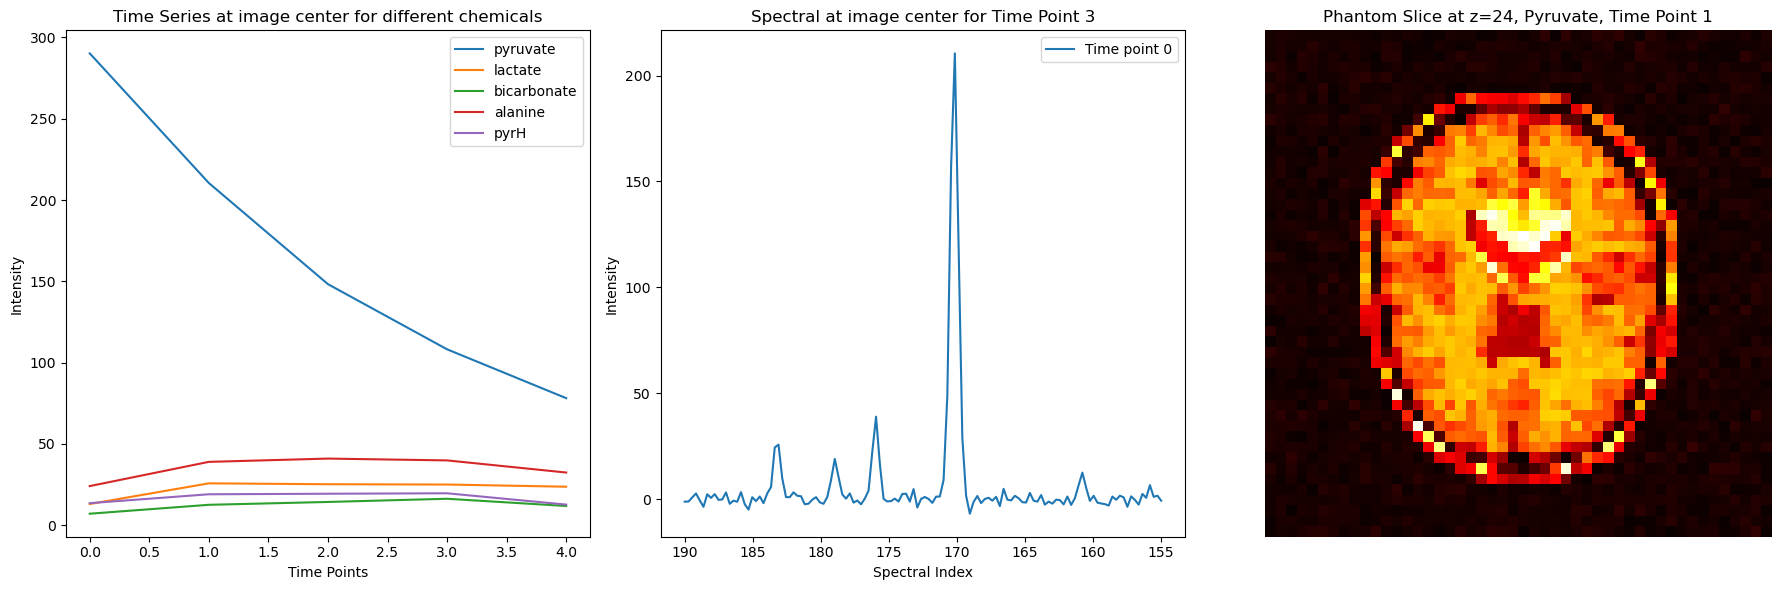

In [52]:

# Assuming nx, ny, nz, spectral_length, time_points are dimensions of the phantom
nx, ny, nz, spectral_length, time_points = image.shape

# Determine the center of the image slice
center_x, center_y, center_z = nx // 2, ny // 2, nz//2

# Determine the position of each chemical in 5D image

ppm_scale = phantom_generator.ppm_scale
chemical_shifts = phantom_generator.chemical_shifts

# Find the index of the peak for each chemical
peak_indices = {}
for chem, shift in chemical_shifts.items():
    peak_index = np.argmin(np.abs(ppm_scale - shift))
    peak_indices[chem] = peak_index


# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Time series at specific indices
peak_index = {}
for chem, shift in chemical_shifts.items():
    peak_index = np.argmin(np.abs(ppm_scale - shift))
    peak_indices[chem] = peak_index
    axs[0].plot(image[center_x, center_y, center_z, peak_index, :], label=chem)

axs[0].set_xlabel('Time Points')
axs[0].set_ylabel('Intensity')
axs[0].set_title('Time Series at image center for different chemicals')
axs[0].legend()

# Second subplot: Spectral data at a specific time point
axs[1].plot(phantom_generator.ppm_scale, image[center_x, center_y, center_z, :, 1], label='Time point 0')
axs[1].invert_xaxis()
axs[1].set_xlabel('Spectral Index')
axs[1].set_ylabel('Intensity')
axs[1].set_title('Spectral at image center for Time Point 3')
axs[1].legend()

# Third subplot: Image of the phantom at a specific slice, spectral index, and time point
image_slice = np.abs(image[:, :, center_z, peak_indices['pyruvate'], 1])
axs[2].imshow(image_slice, cmap='hot')
axs[2].set_title(f'Phantom Slice at z={center_z}, Pyruvate, Time Point 1')
axs[2].axis('off')  # Hide axis for the image

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### Gradient waveforms generation through a Matlab script taking into account the hardware constraints. 

In [53]:
# TN, WN, MW, RN, FOV, DPnkDW, kDW, maxDG_Tpms

eng = matlab.engine.start_matlab()
eng.addpath('/Users/christophermarouani/Desktop/Code_vesco_2D')

points_per_wave = 8192
number_of_waves = 3500
MM = 20
RNx = 48
RNy = 48
RNz = 48
fOV = 48e-2
DPnkDW = 512e-6
kDW = 32e-6
maxDG_Tpms = 15


# The Matlab script should ouptut the desire encoding gradients
# to put on the GE scanner sacled according to the differenet parameters of the acquisition

enc_g = eng.write_5D_LFRwaves_1H(points_per_wave, number_of_waves, MM, RNx, RNy, RNz, fOV, DPnkDW, kDW, maxDG_Tpms, 1)
eng.quit()

enc_g = np.array(enc_g)
enc_g = np.swapaxes(enc_g, 0, 1)


Encoding FOV = 0.48 m, with 48 points, resolution = 10 mm
Acquisition Time = 0.032768 s with 8192 points, dwell time = 4 us
Requires Gx = 2988.1795 Hz/m, 2e-01 % of max G = 1277291.5422 Hz/m
Requires Gy = 2988.1795 Hz/m, 2e-01 % of max G = 1277291.5422 Hz/m
Requires Gz = 2988.1795 Hz/m, 2e-01 % of max G = 1277291.5422 Hz/m
Minimum paired sinc length = 425 for maxG-DG = 1277291.5422-638645771.1
Maximum waveforms = 19, requested = 20
K-space reachable = 47
mean/max slew rate = 4.2515/14.2808
% of max slew rate = 95.2053
Minimum paired sinc length = 425 for maxG-DG = 1277291.5422-638645771.1
Maximum waveforms = 19, requested = 20
K-space reachable = 47
mean/max slew rate = 4.247/14.2808
% of max slew rate = 95.2053
Minimum paired sinc length = 425 for maxG-DG = 1277291.5422-638645771.1
Maximum waveforms = 19, requested = 20
K-space reachable = 47
mean/max slew rate = 4.2144/14.2808
% of max slew rate = 95.2053
Writing GE struct ...
gmax = 4.4607 [mT/m] = 0.44607 [G/cm]
smax = 14.2808 [T/m

### Summary plots of the encoding gradients.

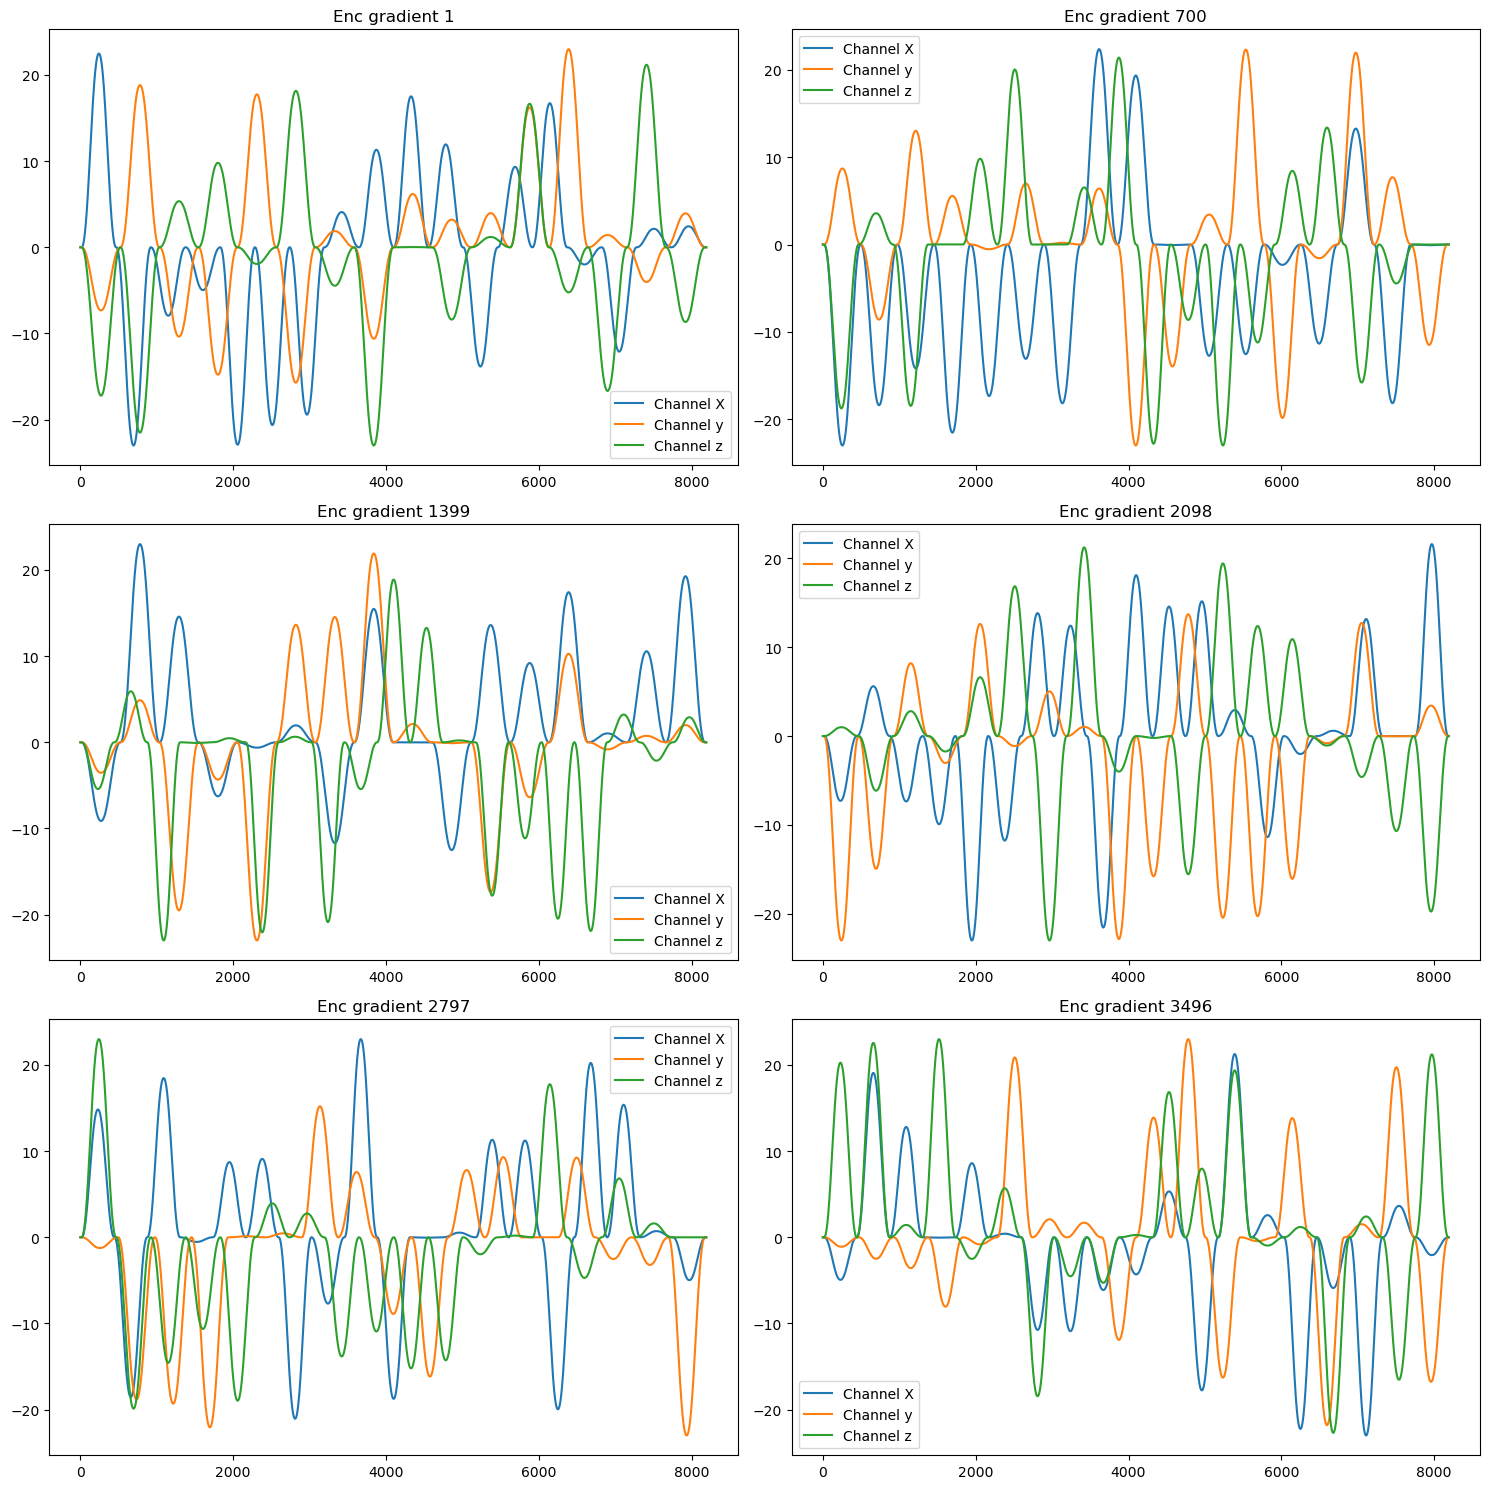

In [57]:
# Plot of the encoding gradients
num_slices = enc_g.shape[0] - 1
interval = max(1, int(num_slices // 5))

# Define the total number of points to plot
plot_points = list(range(1, num_slices, interval))

# Calculate the number of rows and columns for the grid
num_cols = 2  # Adjust this to fit your preference
num_rows = int(np.ceil(len(plot_points) / num_cols))

# Setting up the plot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))  # Adjust the figure size as needed

for idx, i in enumerate(plot_points):
    row = idx // num_cols
    col = idx % num_cols
    ax = axs[row, col]
    ax.plot(enc_g[i, :, 1], label='Channel X')
    ax.plot(enc_g[i, :, 0], label='Channel y')
    ax.plot(enc_g[i, :, 2], label='Channel z')
    ax.set_title(f'Enc gradient {i}')
    ax.legend()

# Hide any remaining empty subplots
for j in range(idx + 1, num_rows * num_cols):
    fig.delaxes(axs.flat[j])

# Adjust layout
plt.tight_layout()
plt.show()


## Sampling of the 5D kspace accordingly to the gradients.

In [69]:
# Function to get k-space locations from k-space gradients
@njit
def gridding_enc_g_floor(one_wave_kgrad):
    return np.round(one_wave_kgrad).astype(np.int64)


@njit(parallel=True)
def make_sampling_5D_kspace(kspace, kgrad):
    n_waves, n_points_per_wave, space_dim = kgrad.shape
    shape_arr = np.array(kspace.shape)
    ns = shape_arr[space_dim]
    nt = shape_arr[space_dim+1]
    space_shape = shape_arr[:space_dim]
    off_set = space_shape // 2
    sampled_kspace = np.zeros_like(kspace)
    kspace_locs = gridding_enc_g_floor(kgrad) + off_set

    n_points_per_spec = n_points_per_wave // ns
    if n_points_per_spec == 0:
        raise ValueError("You need to have more points per waveform than the spectral dimension")

    n_waves_per_time_point = n_waves // nt

    for t in prange(nt):
        for i in range(n_waves_per_time_point):
            wave_number = i + t * n_waves_per_time_point
            for g_point in range(n_points_per_wave):
                kx, ky, kz = kspace_locs[wave_number, g_point]
                s = (ns * g_point) // n_points_per_wave
                sampled_kspace[kx, ky, kz, s, t] = kspace[kx, ky, kz, s, t]

    return sampled_kspace

image = phantom[:, :, :, :, [1, 2, 3, 4, 5]]
print(image.shape)

# Reshape the array to (48, 48, 48, 32, 4, 5)
image =  image.reshape(48, 48, 48, 32, 4, 5)

# Take the mean over the 5th dimension (the original 4th dimension)
image = image.mean(axis=4)

(nx, ny, nz, ns, nt) = image.shape

kspace = np.fft.fftn(image, norm='ortho')

shifted_kspace = np.fft.fftshift(kspace, axes=(0, 1, 2))
shifted_sampled_kspace = make_sampling_5D_kspace(shifted_kspace, enc_g)
mask = shifted_sampled_kspace != 0
sampled_kspace = np.fft.ifftshift(shifted_sampled_kspace, axes=(0, 1, 2))

# Compute and print k-space sparsity
kspace_sparsity = np.sum(np.abs(sampled_kspace) == 0) / np.prod(kspace.shape)
print(f"K-space sparsity: {kspace_sparsity}")


(48, 48, 48, 128, 5)
K-space sparsity: 0.8680534645363137


### Summary plots of the sampling.

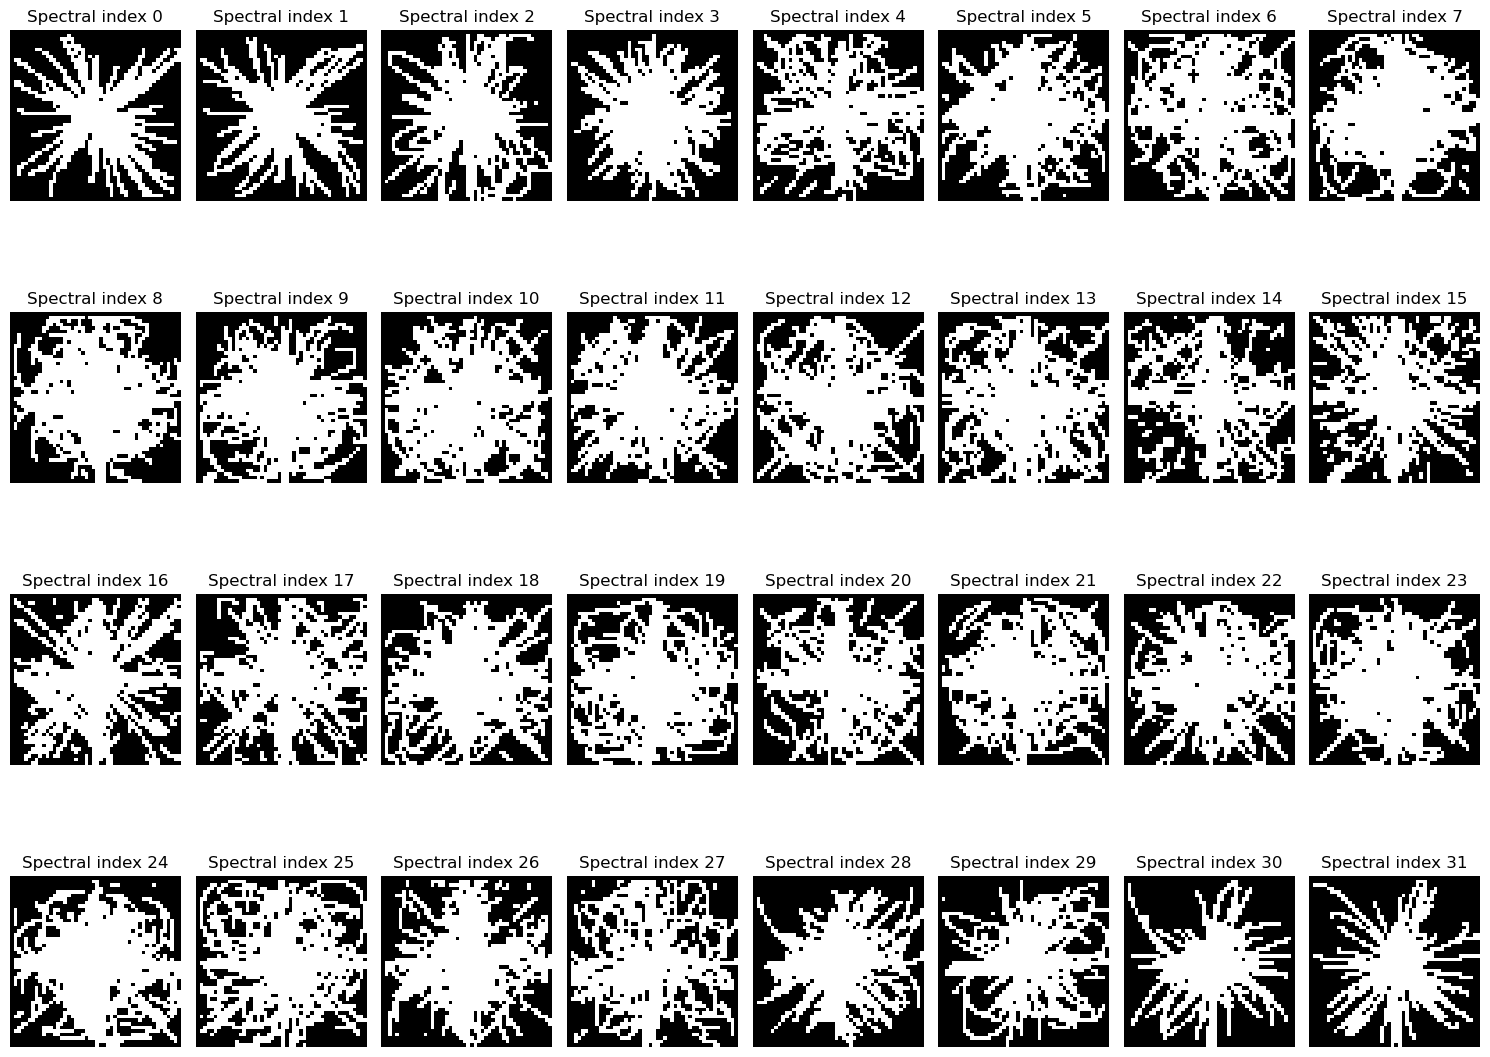

In [70]:
# Calculate the number of rows and columns for the grid
num_cols = 8  # You can adjust this to fit your preference
num_rows = int(np.ceil(ns / num_cols))

# Setting up the plot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))  # Adjust the figure size as needed

for i in range(ns):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    ax.imshow(mask[:, :, 24, i, 0], cmap='gray')
    ax.set_title(f'Spectral index {i}')
    ax.axis('off')  # Hide axes

# Hide any remaining empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flat[j])

# Adjust layout
plt.tight_layout()
plt.show()


### Radius distribution of the sampling strategy.

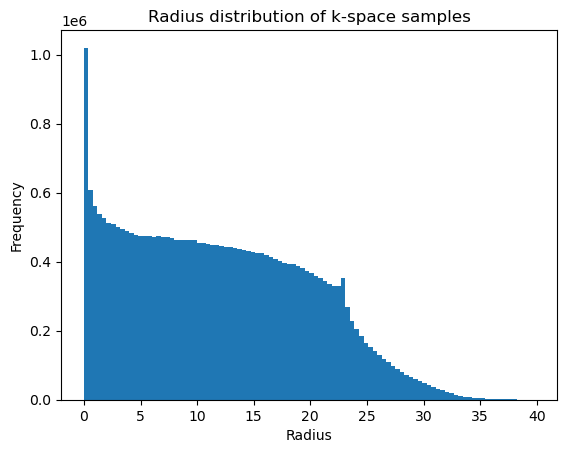

In [71]:
# plot the histogram of the radius distribution of the k-space samples
radii = np.linalg.norm(enc_g, axis=2)
radii = radii.flatten()
plt.hist(radii, bins=100)
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.title('Radius distribution of k-space samples')
plt.show()


## Compress sensing framework.

In [72]:
# MRI_Reconstrucotr class inspired my skleanr API where .fit() is the iteration of
# the reconstruction
# and .transform() is the final reconstruction (gtpd)

class MRI_Reconstructor:
    def __init__(self,
                 n_dim,
                 L=1,
                 prior=0,
                 prior_domain='None',
                 prior_coeff=0.04):

        self.n_dim = n_dim
        self.prior = prior
        self.prior_coeff = prior_coeff
        self.prior_domain = prior_domain
        self.L = L

    def reconstruct(self, undersampled_kspace, n_iter=100):

        shape = undersampled_kspace.shape
        size = undersampled_kspace.size

        d = undersampled_kspace

        mask = np.abs(d) > 0

        d = d.ravel()
        d = d[mask.ravel() == 1]

        if self.n_dim == 1:

            Fourier_operator = pylops.signalprocessing.FFT(dims=shape,
                                                           norm='ortho')

        elif self.n_dim == 2 :

            Fourier_operator = pylops.signalprocessing.FFT2D(dims=shape,
                                                             norm='ortho')

        elif self.n_dim == 3 :

            Fourier_operator = pylops.signalprocessing.FFTND(dims=shape,
                                                             norm='ortho')

        else :

            Fourier_operator = pylops.signalprocessing.FFTND(dims=shape,
                                                             axes=(-5, -4, -3, -2, -1),
                                                             norm='ortho')

        Mask_operator = pylops.Restriction(size,
                                           np.where(mask.ravel() == 1)[0],
                                           dtype=np.complex128)

        Dop = Mask_operator * Fourier_operator

        with pylops.disabled_ndarray_multiplication():

            sigma = self.prior_coeff

            data_fidelity = pyproximal.proximal.L2(Op=Dop,
                                                   b=d,
                                                   niter=50)
            if self.prior_domain == 'None':
                self.prior_domain = pylops.Identity(size)

            # Gop = sigma*pylops.signalprocessing.FFT(dims=shape)

            Gop = sigma * self.prior_domain

            L = self.L
            tau = .99 / np.sqrt(L)
            mu = .99 / np.sqrt(L)
            gtpd = pyproximal. optimization.primaldual.PrimalDual(
                                data_fidelity,
                                self.prior,
                                Gop,
                                x0=np.zeros(size).ravel(),
                                tau=tau,
                                mu=mu,
                                theta=1.0,
                                niter=n_iter,
                                show=True)

        reconstruction = gtpd.reshape(shape)

        return reconstruction


### Optimization reconstruction.

In [75]:

model = MRI_Reconstructor(
                        n_dim=5,
                        prior=pyproximal.L1(),
                        prior_coeff=1,
                        L=1)

n_iter = 60
CS_recon = model.reconstruct(sampled_kspace, n_iter=n_iter)
zero_filled_recon = np.fft.ifftn(sampled_kspace, norm='ortho')

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.linearoperator._ScaledLinearOperator'>
Additional vector (z): None
tau = 0.99		mu = 0.99
theta = 1.00		niter = 60

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1  -1.50180e-01   2.630e+07   8.518e+06   0.000e+00       3.482e+07
     2   5.36215e-02   8.930e+06   7.202e+06   0.000e+00       1.613e+07
     3   7.14514e-02   3.835e+06   7.741e+06   0.000e+00       1.158e+07
     4   5.11848e-02   2.163e+06   8.027e+06   0.000e+00       1.019e+07
     5   3.62576e-02   1.533e+06   8.088e+06   0.000e+00       9.621e+06
     6   1.82364e-02   1.257e+06   8.057e+06   0.000e+00       9.314e+06
     7   5.84875e-03   1.119e+06   7.998e+06   0.000e+00       9.117e+06
     8   4.85933e-03   1.042e+06   7.938e+06  

## Chemicals selection. 

In [76]:

# Optimized find_amplitudes_chemicals function
def find_amplitudes_chemicals(spectrum, n_peaks=5, threshold=0):
    peaks, _ = find_peaks(np.abs(spectrum), threshold=threshold)
    peak_amplitudes = np.abs(spectrum[peaks])
    top_n_peaks_indices = np.argsort(peak_amplitudes)[-n_peaks:]
    top_n_peaks = peak_amplitudes[top_n_peaks_indices]

    if len(top_n_peaks) < n_peaks:
        return np.pad(top_n_peaks, (0, n_peaks - len(top_n_peaks)), 'constant')

    return top_n_peaks

# Optimized make_chemicals_images function with parallel processing
def process_voxel(recon, x, y, z, n_chemicals, threshold, n_time):
    chemical_amplitudes = np.zeros((n_chemicals, n_time), dtype=np.complex128)
    for t in range(n_time):
        amplitudes = find_amplitudes_chemicals(recon[x, y, z, :, t], n_peaks=n_chemicals, threshold=threshold)
        chemical_amplitudes[:, t] = amplitudes
    return (x, y, z, chemical_amplitudes)

# Taking the 5 most intense peaks for each voxel to create the chemical images
def make_chemicals_images(recon, n_chemicals=5, threshold=0):
    nx, ny, nz, _, n_time = recon.shape
    chemicals_images_time = np.zeros((nx, ny, nz, n_chemicals, n_time), dtype=np.complex128)

    results = Parallel(n_jobs=-1)(delayed(process_voxel)(recon, x, y, z, n_chemicals, threshold, n_time)
                                  for x in range(nx) for y in range(ny) for z in range(nz))

    for x, y, z, chemical_amplitudes in results:
        chemicals_images_time[x, y, z, :, :] = chemical_amplitudes

    return chemicals_images_time


chemicals_images = make_chemicals_images(image, n_chemicals=5, threshold=0)
recon_chemicals_images = make_chemicals_images(CS_recon, n_chemicals=5, threshold=0)
zf_chemicals_images = make_chemicals_images(zero_filled_recon, n_chemicals=5, threshold=0)


### Final plots of the reconstructed image.

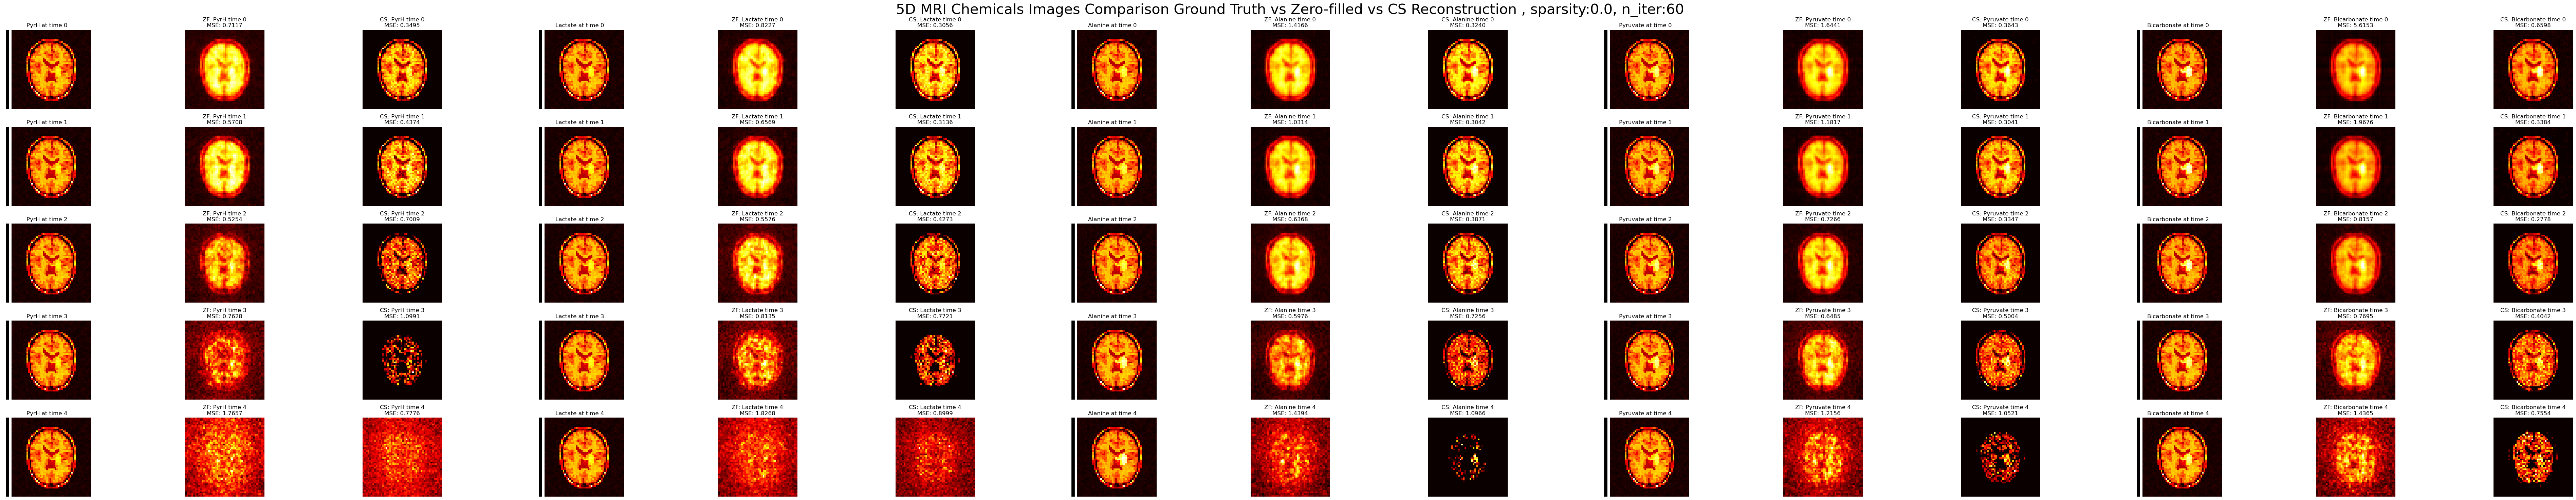

In [80]:
(nx, ny, nz, ns, nt) = chemicals_images.shape
kspace_sparsity = np.sum(np.abs(kspace) == 0) / np.prod(kspace.shape)
# Define the chemical names
chemical_names = ['PyrH', 'Lactate', 'Alanine', 'Pyruvate', 'Bicarbonate']

# Get the number of chemicals and time points
num_chemicals = len(chemical_names)
num_timepoints = chemicals_images.shape[-1]

# Create a figure and a set of subplots with num_timepoints rows and 3 columns for each chemical
fig, axs = plt.subplots(num_timepoints, 3 * num_chemicals, figsize=(80, 15), squeeze=True)

# Loop over each chemical
for i in range(num_chemicals):
    # Loop over each time point
    for t in range(num_timepoints):
        # Extract the images at the specified slice (Z index nz//2) for the chemical and time point
        gt_image = chemicals_images[:, :, nz//2, i, t]
        norm_gt = np.linalg.norm(gt_image)
        zf_image = zf_chemicals_images[:, :, nz//2, i, t]
        recon_image = recon_chemicals_images[:, :, nz//2, i, t]


        # Compute MSE for Zero-filled and CS reconstruction
        mse_zf = 100*mean_squared_error(np.abs(gt_image), np.abs(zf_image))/norm_gt
        mse_recon = 100*mean_squared_error(np.abs(gt_image), np.abs(recon_image))/norm_gt

        # Ground Truth image
        axs[t, 3 * i].imshow(np.abs(gt_image), cmap='hot')
        axs[t, 3 * i].set_title(f'{chemical_names[i]} at time {t}')
        axs[t, 3 * i].axis('off')  # Hide axis for images


        # Zero-filled Reconstruction image
        axs[t, 3 * i + 1].imshow(np.abs(zf_image), cmap='hot')
        axs[t, 3 * i + 1].set_title(f'ZF: {chemical_names[i]} time {t}\nMSE: {mse_zf:.4f}')
        axs[t, 3 * i + 1].axis('off')  # Hide axis for images

        # CS Reconstruction image
        axs[t, 3 * i + 2].imshow(np.abs(recon_image), cmap='hot')
        axs[t, 3 * i + 2].set_title(f'CS: {chemical_names[i]} time {t}\nMSE: {mse_recon:.4f}')
        axs[t, 3 * i + 2].axis('off')  # Hide axis for images

# Draw vertical lines to separate chemicals
for i in range(0, num_chemicals):
    for t in range(num_timepoints):
            axs[t, 3 * i ].axvline(x=-3, color='k', linewidth=7)  # Adjust x to control position of the line

plt.suptitle(f'5D MRI Chemicals Images Comparison Ground Truth vs Zero-filled vs CS Reconstruction , sparsity:{kspace_sparsity}, n_iter:{n_iter}', fontsize=30)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
